In [74]:
import numpy as np
import tensorflow as tf
from keras import Model, layers, optimizers, losses, metrics,callbacks
from keras_gcnn.layers import GConv2D, GBatchNorm, GroupPool

import matplotlib.pyplot as plt

In [ ]:
from data.cifar.train import get_cifar10_data

train_data, train_labels, val_data, val_labels = get_cifar10_data(datadir="./data/cifar",
                                                                  trainfn="train_all.npz",
                                                                  valfn="test.npz")

Preprocessing...
   Loading...
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
   Normalizing...
   Computing whitening matrix...
   Whitening data...
   Saving...
Preprocessing complete


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.5889053..5.651184].


(32, 32, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


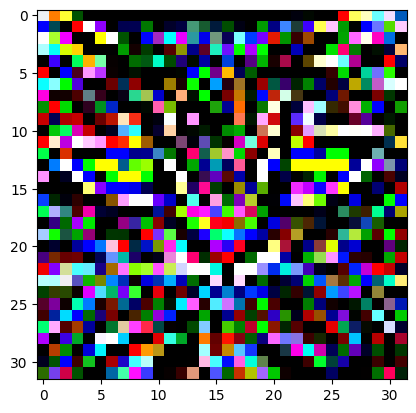

In [ ]:


img = train_data[8000]

img = tf.constant(np.moveaxis(img, 0, 2), dtype=img.dtype)

print(img.shape, type(img))
plt.imshow(img)



In [54]:
train_data = tf.constant([np.moveaxis(img, 0, 2) for img in train_data], dtype=img.dtype)

In [55]:
val_data = tf.constant([np.moveaxis(img, 0, 2) for img in val_data], dtype=img.dtype)

In [56]:
print(train_data.shape, val_data.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


## Reproducing Experiments

### All-CNN

In [ ]:
inputs = layers.Input((32, 32, 3))

out_channels = [96, 96, 96, 192, 192, 192, 192, 192, 10]
ksizes = [3, 3, 3, 3, 3, 3, 3, 1, 1]
strides = [1, 1, 2, 1, 1, 2, 1, 1, 1]

x = layers.Dropout(0.2)(inputs)
for out_c, ksize, stride in zip(out_channels, ksizes, strides):
        padding =  "valid" if (ksize == 1) else "same"
        x = layers.Conv2D(out_c, ksize, stride, padding=padding)(x)
        x = layers.Activation('relu')(x)
        x = layers.BatchNormalization()(x)

        if stride ==2:
                x = layers.Dropout(0.5)(x)

x = layers.GlobalAveragePooling2D()(x)

allcnn = Model(inputs=inputs, outputs=x)
allcnn.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_105 (Activation)     │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_106 (Activation)     │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 16, 16, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_107 (Activation)     │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 16, 16, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_108 (Activation)     │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 16, 16, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_109 (Activation)     │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_110 (Activation)     │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_135 (Conv2D)             │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_111 (Activation)     │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 8, 8, 192)      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_112 (Activation)     │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 8, 8, 10)       │         1,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_113 (Activation)     │ (None, 8, 8, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,369,738 (5.23 MB)

 Trainable params: 1,369,738 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
def scheduler(epoch, lr):
    if epoch in  (200, 250, 300):
        return lr * 0.1
    else:
        return lr

In [93]:
allcnn.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.05,
        momentum=0.9,
        weight_decay=0.001
    ),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.sparse_categorical_accuracy],
)

history = allcnn.fit(
    train_data,
    train_labels,
    batch_size=128,
    epochs=10,
    callbacks=[callbacks.LearningRateScheduler(scheduler)],
    validation_split=1/5,
    validation_batch_size=1000,
)

result = allcnn.evaluate(val_data, val_labels)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - loss: 2.2991 - sparse_categorical_accuracy: 0.1012 - val_loss: 2.3024 - val_sparse_categorical_accuracy: 0.0903 - learning_rate: 0.0500
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - loss: 2.2972 - sparse_categorical_accuracy: 0.1066 - val_loss: 2.2973 - val_sparse_categorical_accuracy: 0.0909 - learning_rate: 0.0500
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - loss: 2.2817 - sparse_categorical_accuracy: 0.1133 - val_loss: 2.2109 - val_sparse_categorical_accuracy: 0.1964 - learning_rate: 0.0500
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - loss: 2.0983 - sparse_categorical_accuracy: 0.2303 - val_loss: 1.7827 - val_sparse_categorical_accuracy: 0.3761 - learning_rate: 0.0500
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - loss: 1.7504 - sparse_categorical_accuracy: 0.3835 - val_loss: 1.5446 - val_sparse_categorical_accuracy: 0.4702 - learning_rate: 0.0500
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━

In [85]:
allcnn.save("./allcnn.keras")

### All-P4CNN

In [98]:
inputs = layers.Input((32, 32, 3))

out_channels = [48, 48, 48, 96, 96, 96, 96, 96, 10]
ksizes = [3, 3, 3, 3, 3, 3, 3, 1, 1]
strides = [1, 1, 2, 1, 1, 2, 1, 1, 1]

x = layers.Dropout(0.2)(inputs)
h_in = 'Z2'
for out_c, ksize, stride in zip(out_channels, ksizes, strides):
        padding =  "valid" if (ksize == 1) else "same"
        x = GConv2D(out_c, ksize, h_in, 'C4', stride, padding=padding)(x)
        h_in = 'C4'
        x = layers.Activation('relu')(x)

        if stride ==2:
                x = layers.Dropout(0.5)(x)

x = layers.Reshape((8, 8, 4, 10)) (x)
x = layers.GlobalAveragePooling3D()(x)

allp4cnn = Model(inputs=inputs, outputs=x)
allp4cnn.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_81 (GConv2D)           │ (None, 32, 32, 192)    │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_195 (Activation)     │ (None, 32, 32, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_82 (GConv2D)           │ (None, 32, 32, 192)    │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_196 (Activation)     │ (None, 32, 32, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_83 (GConv2D)           │ (None, 16, 16, 192)    │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_197 (Activation)     │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_84 (GConv2D)           │ (None, 16, 16, 384)    │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_198 (Activation)     │ (None, 16, 16, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_85 (GConv2D)           │ (None, 16, 16, 384)    │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_199 (Activation)     │ (None, 16, 16, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_86 (GConv2D)           │ (None, 8, 8, 384)      │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_200 (Activation)     │ (None, 8, 8, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8, 8, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_87 (GConv2D)           │ (None, 8, 8, 384)      │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_201 (Activation)     │ (None, 8, 8, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_88 (GConv2D)           │ (None, 8, 8, 384)      │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_202 (Activation)     │ (None, 8, 8, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_89 (GConv2D)           │ (None, 8, 8, 40)       │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_203 (Activation)     │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 8, 8, 4, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_6      │ (None, 10)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,369,104 (5.22 MB)

 Trainable params: 1,369,104 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
allp4cnn.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.05,
        momentum=0.9,
        weight_decay=0.001
    ),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.sparse_categorical_accuracy],
)

history = allp4cnn.fit(
    train_data,
    train_labels,
    batch_size=128,
    epochs=10,
    callbacks=[callbacks.LearningRateScheduler(scheduler)],
    validation_split=1/5,
    validation_batch_size=1000,
)

result = allp4cnn.evaluate(val_data, val_labels)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 217ms/step - loss: 2.3014 - sparse_categorical_accuracy: 0.1028 - val_loss: 2.2821 - val_sparse_categorical_accuracy: 0.1224 - learning_rate: 0.0500
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - loss: 2.3006 - sparse_categorical_accuracy: 0.1141 - val_loss: 2.2985 - val_sparse_categorical_accuracy: 0.1292 - learning_rate: 0.0500
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - loss: 2.2947 - sparse_categorical_accuracy: 0.1045 - val_loss: 2.2817 - val_sparse_categorical_accuracy: 0.1220 - learning_rate: 0.0500
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - loss: 2.2845 - sparse_categorical_accuracy: 0.1133 - val_loss: 2.2732 - val_sparse_categorical_accuracy: 0.1245 - learning_rate: 0.0500
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - loss: 2.2600 - sparse_categorical_accuracy: 0.1223 - val_loss: 2.2297 - val_sparse_categorical_accuracy: 0.1303 - learning_rate: 0.0500
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━

### All P4M CNN

In [99]:
inputs = layers.Input((32, 32, 3))

out_channels = [32, 32, 32, 64, 64, 64, 64, 64, 10]
ksizes = [3, 3, 3, 3, 3, 3, 3, 1, 1]
strides = [1, 1, 2, 1, 1, 2, 1, 1, 1]

x = layers.Dropout(0.2)(inputs)
h_in = 'Z2'
for out_c, ksize, stride in zip(out_channels, ksizes, strides):
        padding =  "valid" if (ksize == 1) else "same"
        x = GConv2D(out_c, ksize, h_in, 'D4', stride, padding=padding)(x)
        h_in = 'D4'
        x = layers.Activation('relu')(x)

        if stride ==2:
                x = layers.Dropout(0.5)(x)

x = layers.Reshape((8, 8, 8, 10)) (x)
x = layers.GlobalAveragePooling3D()(x)

allp4mcnn = Model(inputs=inputs, outputs=x)
allp4mcnn.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_90 (GConv2D)           │ (None, 32, 32, 256)    │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_204 (Activation)     │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_91 (GConv2D)           │ (None, 32, 32, 256)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_205 (Activation)     │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_92 (GConv2D)           │ (None, 16, 16, 256)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_206 (Activation)     │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_93 (GConv2D)           │ (None, 16, 16, 512)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_207 (Activation)     │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_94 (GConv2D)           │ (None, 16, 16, 512)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_208 (Activation)     │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_95 (GConv2D)           │ (None, 8, 8, 512)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_209 (Activation)     │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_96 (GConv2D)           │ (None, 8, 8, 512)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_210 (Activation)     │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_97 (GConv2D)           │ (None, 8, 8, 512)      │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_211 (Activation)     │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_98 (GConv2D)           │ (None, 8, 8, 80)       │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_212 (Activation)     │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 8, 8, 8, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_7      │ (None, 10)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,218,400 (4.65 MB)

 Trainable params: 1,218,400 (4.65 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
allp4mcnn.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.05,
        momentum=0.9,
        weight_decay=0.001
    ),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.sparse_categorical_accuracy],
)

history = allp4mcnn.fit(
    train_data,
    train_labels,
    batch_size=128,
    epochs=10,
    callbacks=[callbacks.LearningRateScheduler(scheduler)],
    validation_split=1/5,
    validation_batch_size=1000,
)

result = allp4mcnn.evaluate(val_data, val_labels)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 2.2987 - sparse_categorical_accuracy: 0.1010

2025-03-25 15:16:40.195633: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng11{k2=0,k3=0} for conv %cudnn-conv-bias-activation.12 = (f32[1000,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1000,256,32,32]{3,2,1,0} %bitcast.1054, f32[256,256,3,3]{3,2,1,0} %bitcast.1066, f32[256]{0} %bitcast.1069), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_19_1/g_conv2d_73_1/convolution" source_file="/home/jquinteros/tfcode/tfenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-03-25 15:16:40.222242: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation 

313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 320ms/step - loss: 2.2987 - sparse_categorical_accuracy: 0.1010 - val_loss: 2.3025 - val_sparse_categorical_accuracy: 0.1018 - learning_rate: 0.0500
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 158ms/step - loss: 2.2698 - sparse_categorical_accuracy: 0.1250 - val_loss: 2.0078 - val_sparse_categorical_accuracy: 0.2695 - learning_rate: 0.0500
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - loss: 1.9448 - sparse_categorical_accuracy: 0.2966 - val_loss: 1.6774 - val_sparse_categorical_accuracy: 0.4359 - learning_rate: 0.0500
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - loss: 1.6089 - sparse_categorical_accuracy: 0.4372 - val_loss: 1.3056 - val_sparse_categorical_accuracy: 0.5533 - learning_rate: 0.0500
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - loss: 1.2884 - sparse_categorical_accuracy: 0.5632 - val_loss: 1.0409 - val_sparse_categorical_accuracy: 0.6505 - learning_rate: 0.0500
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 1

In [ ]:
for model in (allcnn, allp4cnn, allp4mcnn):
    model.compile(
        optimizer=optimizers.SGD(
            learning_rate=0.05,
            momentum=0.9,
            weight_decay=0.001
        ),
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[metrics.sparse_categorical_accuracy],
    )

    history = model.fit(
        train_data,
        train_labels,
        batch_size=128,
        epochs=350,
        callbacks=[callbacks.LearningRateScheduler(scheduler)],
        validation_split=1/5,
        validation_batch_size=1000,
        verbose=1
    )

    result = model.evaluate(val_data, val_labels)

Epoch 1/350
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 109ms/step - loss: 2.3013 - sparse_categorical_accuracy: 0.1029 - val_loss: 2.2870 - val_sparse_categorical_accuracy: 0.1660 - learning_rate: 0.0500
Epoch 2/350
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - loss: 2.2914 - sparse_categorical_accuracy: 0.1301 - val_loss: 2.2121 - val_sparse_categorical_accuracy: 0.1793 - learning_rate: 0.0500
Epoch 3/350
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 2.1457 - sparse_categorical_accuracy: 0.2074 - val_loss: 1.9574 - val_sparse_categorical_accuracy: 0.3044 - learning_rate: 0.0500
Epoch 4/350
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 1.8125 - sparse_categorical_accuracy: 0.3522 - val_loss: 1.4897 - val_sparse_categorical_accuracy: 0.4789 - learning_rate: 0.0500
Epoch 5/350
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - loss: 1.4987 - sparse_categorical_accuracy: 0.4834 - val_loss: 1.2370 - val_sparse_categorical_accuracy: 0.5795 - learning_rate: 0.0500
Epoch 6/350
313/313 ━━━━━━━━━━

In [101]:
allp4cnn.save("./allp4cnn.keras")
allp4mcnn.save("./allp4mcnn.keras")

In [102]:
for model_name in ("allcnn", "allp4cnn", "allp4mcnn"):
    model = tf.keras.models.load_model(model_name + ".keras")
    model.evaluate(val_data, val_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5676 - sparse_categorical_accuracy: 0.8908
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.8854
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.5464 - sparse_categorical_accuracy: 0.9033
